# Arial Cactus Identification with Pytorch and VGG-16

In [23]:
# General libraries imports
import pandas as pd
import numpy as np
import os
import time

# import image manipulation
from PIL import Image

# import matplotlib for visualization
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# Import PyTorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

## Introduction

The goal of the [Aerial Cactus Identification competition](https://www.kaggle.com/c/aerial-cactus-identification) is to create an algorithm that can identify a specific type of cactus in aerial imagery to advance a system for autonomous surveillance of protected areas.

<br>In this competition, we are given a dataset with labeled 32 x 32 images, which contain aerial photos of a columnar cactus. The task is to build an algorithm, which predicts whether there is a cactus on the image. This is a classification problem. Since we have a lot of data, deep learning models will suit well for this problem.

<br>In this analysis I used the code from this [Kaggle kernel](https://www.kaggle.com/atrisaxena/pytorch-simple-model-iscactus-classification).

## Explore Data

Let's explore the dataset given:
* How many records are there in train and test datasets?
* How many images are there with/without cactus?
* Visualize images with and without cactus.

In [28]:
# Set path to folders containing the data
TRAIN_IMG_PATH = "./data/train/"
TEST_IMG_PATH = "./data/test/"
LABELS_CSV_PATH = "./data/train.csv"
SAMPLE_SUB_PATH = "./data/sample_submission.csv"

`1` Number of images in train and test datasets:

In [50]:
# read the csv with labels for train dataset
pd_train = pd.read_csv(LABELS_CSV_PATH)

# count the number or rows
train_images = len(pd_train)

print("The number of images in train dataset is {}.".format(train_images))

The number of images in train dataset is 17500.


In [53]:
# count the number of images in test dataset
test_images = len([f for f in os.listdir(TEST_IMG_PATH) if os.path.isfile(os.path.join(TEST_IMG_PATH, f))])

print("The number of images in test dataset is {}.".format(test_images))

The number of images in test dataset is 4000.


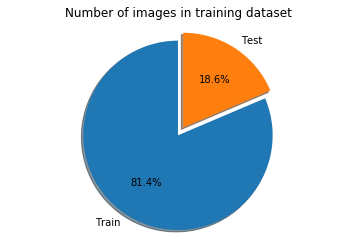

In [73]:
# Plot pie chart
labels = 'Train', 'Test'
sizes = [train_images, test_images]
explode = (0, 0.1)  # "explode" the 2nd slice

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Number of images in training dataset")
plt.show()

`2` Number of images with and without cactus in train dataset:

In [69]:
# calculate the number of images with and without cactus
with_cactus_num = pd_train[pd_train['has_cactus'] == 1].has_cactus.count()
no_cactus_num = pd_train[pd_train['has_cactus'] == 0].has_cactus.count()

print("The number of images with cactus in train dataset is {}.".format(with_cactus_num))
print("The number of images without cactus in train dataset is {}.".format(no_cactus_num))

The number of images with cactus in train dataset is 13136.
The number of images without cactus in train dataset is 4364.


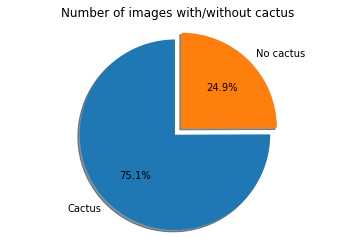

In [74]:
# Plot pie chart
labels = 'Cactus', 'No cactus'
sizes = [with_cactus_num, no_cactus_num]
explode = (0, 0.1)  # "explode" the 2nd slice

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Number of images with/without cactus")
plt.show()

`3` View examples of images with cactus and without cactus:

In [38]:
# get array of image filenames with and without cactus
has_cactus = pd_train[pd_train['has_cactus'] == 1][:9].id.values
no_cactus = pd_train[pd_train['has_cactus'] == 0][:9].id.values

In [54]:
def view_cactus(cactus_images, title = ''):
    """
    Function to plot grid with several examples of images.
    INPUT:
        cactus_images - array with filenames for images

    OUTPUT: None
    """
    fig, axs = plt.subplots(3, 3, figsize=(7,7))
    
    for im in range(0,9):
        # open image
        image = Image.open(os.path.join(TRAIN_IMG_PATH,cactus_images[im]))
        i = im // 3
        j = im % 3
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')

    # set suptitle
    plt.suptitle(title)
    plt.show()

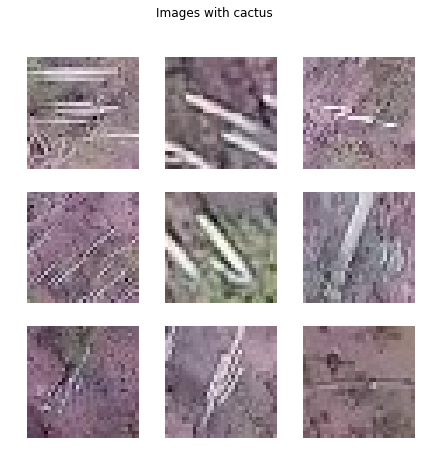

In [55]:
view_cactus(has_cactus, title = 'Images with cactus')

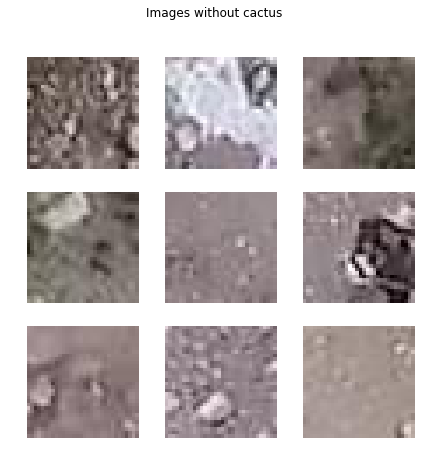

In [56]:
view_cactus(no_cactus, title = 'Images without cactus')

## Modelling

I decided to use VGG-16 pretrained model (see [this article](https://hackernoon.com/learning-keras-by-implementing-vgg16-from-scratch-d036733f2d5) for further reading) to classify the images.

`1` Load the dataset:

In [5]:
# Define the dataset
class CactusDataset(Dataset):
    """Cactus identification dataset."""

    def __init__(self, img_dir, dataframe, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.        
            dataframe (pandas.core.frame.DataFrame): Pandas dataframe obtained
                by read_csv().
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels_frame.id[idx]) 
        image = Image.open(img_name)
        label = self.labels_frame.has_cactus[idx]

        if self.transform:
            image = self.transform(image)

        return [image, label] 
    
# define train transformations   
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       # resize to 224 to meet the VGG-16 pretrained model requirements
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
# define test strnsformations
test_transforms = transforms.Compose([transforms.Resize(256),
                                      # resize to 224 to meet the VGG-16 pretrained model requirements
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

In [3]:
dframe = pd.read_csv(LABELS_CSV_PATH)
cut = int(len(dframe)*0.95)
train, test = np.split(dframe, [cut], axis=0)
test = test.reset_index(drop=True)

train_ds = CactusDataset(TRAIN_IMG_PATH, train, train_transforms)
test_ds = CactusDataset(TRAIN_IMG_PATH, test, test_transforms)
datasets = {"train": train_ds, "val": test_ds}

In [4]:
trainloader = DataLoader(train_ds, batch_size=32,
                        shuffle=True, num_workers=0)

testloader = DataLoader(test_ds, batch_size=4,
                        shuffle=True, num_workers=0)

`2` Setup hyperparameters:

In [5]:
epochs = 5
batch_size = 128
learning_rate = 0.003
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

`3` Load pretrained VGG-16 model:

In [6]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/.torch/models/vgg16-397923af.pth
553433881it [00:24, 22704827.16it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

`4` Train the model:

In [7]:
# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Add layers to train
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 12000)),
                          ('dr1', nn.Dropout(p = 0.3)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(12000, 1000)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(1000, 102)),
                          ('output', nn.LogSoftmax(dim = 1))
                          ]))
    
model.classifier = classifier

In [8]:
# Set loss function
criterion = nn.NLLLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [9]:
# train the model

model.to(device)

steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/5.. Train loss: 67.282.. Test loss: 15.596.. Test accuracy: 0.748
Epoch 1/5.. Train loss: 6.685.. Test loss: 1.391.. Test accuracy: 0.443
Epoch 1/5.. Train loss: 1.085.. Test loss: 2.548.. Test accuracy: 0.749
Epoch 1/5.. Train loss: 1.095.. Test loss: 0.332.. Test accuracy: 0.903
Epoch 1/5.. Train loss: 0.575.. Test loss: 0.396.. Test accuracy: 0.837
Epoch 1/5.. Train loss: 0.361.. Test loss: 0.265.. Test accuracy: 0.874
Epoch 1/5.. Train loss: 0.321.. Test loss: 0.309.. Test accuracy: 0.859
Epoch 1/5.. Train loss: 0.388.. Test loss: 0.238.. Test accuracy: 0.878
Epoch 1/5.. Train loss: 0.234.. Test loss: 0.689.. Test accuracy: 0.792
Epoch 1/5.. Train loss: 0.223.. Test loss: 0.209.. Test accuracy: 0.912
Epoch 1/5.. Train loss: 0.149.. Test loss: 0.486.. Test accuracy: 0.863
Epoch 1/5.. Train loss: 0.228.. Test loss: 0.209.. Test accuracy: 0.942
Epoch 1/5.. Train loss: 0.161.. Test loss: 0.430.. Test accuracy: 0.872
Epoch 1/5.. Train loss: 0.184.. Test loss: 0.376.. Test accura

`5` Create submission:

In [10]:
submission_df = pd.read_csv(SAMPLE_SUB_PATH)
output_df = pd.DataFrame(index=submission_df.index, columns=submission_df.keys() )
output_df['id'] = submission_df['id']
submission_df['target'] =  [0] * len(submission_df)

tdata_transform = transforms.Compose([transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

submission_ds = CactusDataset(TEST_IMG_PATH, submission_df, tdata_transform)

sub_loader = DataLoader(submission_ds, batch_size=1,
                        shuffle=False, num_workers=0)


def test_sumission(model):
    since = time.time()
    sub_outputs = []
    model.train(False)  # Set model to evaluate mode
    # Iterate over data.
    prediction = []
    for data in sub_loader:
        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        prediction.append(int(pred))
      
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return prediction

In [11]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['has_cactus'] = test_sumission(model)
sub.to_csv('submission1.csv', index= False)

sub.head()

Run complete in 0m 46s


,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1


## Credits

Thanks to the following kernels:
1. [Pytorch Simple Model - IsCactus Classification](https://www.kaggle.com/atrisaxena/pytorch-simple-model-iscactus-classification)
2. [Simple CNN on PyTorch for Beginners](https://www.kaggle.com/bonhart/simple-cnn-on-pytorch-for-beginers)